In [1]:
import batch_data_support_general as bds_gen
import importlib
import inspect
import itertools
import logging
import matplotlib.pyplot as plt
import model_attributes as ma
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_electricity as ml
import model_energy as me
import model_socioeconomic as se
import setup_analysis as sa
import sisepuede_data_api as api
import support_classes as sc
import support_functions as sf
import numpy as np
import os, os.path
import pandas as pd
import pycountry
import re
import time
from typing import *
import warnings

warnings.filterwarnings("ignore")


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2300: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


# Load general data


In [4]:
##  READ IN DATA

df_fake_data = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))

# set repository directory for SISEPUEDE Data
dir_repo_data = "/Users/jsyme/Documents/Projects/git_jbus/sisepuede_data"

# set some shared fields
field_country = "country"
field_description = "description"
field_emission_co2e = "emission_mt_co2e"
field_gas = "gas"
field_gas_cw = "gas_climatewatch"
field_ipcc = "IPCC_2006"
field_iso = "ISO"
field_iso3 = "iso_code3"
field_location_code = "location_code"
field_product_code = "product_code"
field_quantity = "quantity"
field_quantity_unit = "quantity_unit"
field_sector_cw = "sector"
field_title_sector = "sector_title"
field_title_subsector = "subsector_title"
field_value = "value"
field_value_thousand_usd = "value_m_usd"
field_year = "year"



##  INITIALIZE SISEPUEDE COMPONENTS--ATTRIBUTES AND MODELS--FOR VAR ACCESS

attr_gas = sa.model_attributes.dict_attributes.get("emission_gas")
attr_ind = sa.model_attributes.dict_attributes.get("cat_industry")
attr_region = sa.model_attributes.dict_attributes.get("region")
attr_time_period = sa.model_attributes.dict_attributes.get(f"dim_{sa.model_attributes.dim_time_period}")

# models
model_energy = me.NonElectricEnergy(sa.model_attributes)
model_ippu = mi.IPPU(sa.model_attributes)
model_socioeconomic = model_energy.model_socioeconomic

# supporting classes
regions = sc.Regions(sa.model_attributes)
time_periods = sc.TimePeriods(sa.model_attributes)

# sisepuede data "api"

repo = api.SISEPUEDEBatchDataRepository(
    dir_repo_data,
    sa.model_attributes
)







# CONSTRUCT KEY SHARED DATASETS
- Production, Initial Energy Consumptions, GDP, Population
    - Used in emission factors and elasticity estimates


In [5]:
# GET INITIAL CONSUMPTION

# variables to read in (key) by categories (value)
dict_modvars = {
    model_energy.modvar_scoe_consumpinit_energy_per_hh_heat: None,
    model_energy.modvar_scoe_consumpinit_energy_per_hh_elec: None,
    model_energy.modvar_scoe_consumpinit_energy_per_mmmgdp_elec: None,
    model_energy.modvar_scoe_consumpinit_energy_per_mmmgdp_heat: None,
    model_ippu.modvar_ippu_prod_qty_init: None,
    model_ippu.model_socioeconomic.modvar_econ_gdp: None,
    model_socioeconomic.modvar_gnrl_area: None,
    model_socioeconomic.modvar_gnrl_elasticity_occrate_to_gdppc: None,
    model_socioeconomic.modvar_gnrl_emission_limit_ch4: None,
    model_socioeconomic.modvar_gnrl_emission_limit_co2: None,
    model_socioeconomic.modvar_gnrl_emission_limit_n2o: None,
    model_socioeconomic.modvar_gnrl_frac_eating_red_meat: None,
    model_socioeconomic.modvar_gnrl_init_occ_rate: None,
    model_socioeconomic.modvar_gnrl_subpop: None,
}



df_inputs = repo.read(dict_modvars, add_time_periods = True)
df_inputs = time_periods.years_to_tps(df_inputs)

df_fd_merge = model_socioeconomic.required_dimensions
df_fd_merge += [
    x for x in df_fake_data.columns 
    if (x in model_socioeconomic.required_variables)
    and (x not in df_inputs.columns)
]
df_fd_merge = df_fake_data[df_fd_merge]

df_inputs = pd.merge(
    df_inputs,
    df_fd_merge,
    how = "left", 
    on = [time_periods.field_time_period]
)
df_inputs.interpolate(method = "bfill", inplace = True)



#########################
#    SETUP FUNCTIONS    #
#########################

def iterative_exogenous_demands_to_sisepuede_ies(
    df_inputs: pd.DataFrame,
    dict_calcs: Dict[str, Dict[str, str]],
    model_attributes: ma.ModelAttributes = sa.model_attributes,
) -> pd.DataFrame:
    """
    Wrapper for bds_gen.exogenous_demands_to_sispeuede_ies; used to 
        streamline code around iteration
        
    Function Arguments
    ------------------
    - df_inputs: input data frame used to calculate elasticities and scalars
    - dict_calcs: dictionary mapping a calculation name to a dictionary of
        model variable inputs; e.g.,
        
        {
            "run_name_0": {
                "modvar_demand: MODVARNAME_DEMAND,
                "modvar_driver": MODVARNAME_DRIVER,
                "modvar_elasticity": MODVARNAME_ELASTICITY,
                "modvar_scalar_demand": MODVARNAME_SCALAR_DEMAND,
            },
            
            "run_name_1": {...}
            .
            .
            .
        }
    
        where each argument `run_name_##` corresponds with a different run of 
        variables and each argument to dict_calcs.get("run_name_##") is one of
        the model variable input function arguments in 
        bds_gen.exogenous_demands_to_sispeuede_ies. See 
        ?bds_gen.exogenous_demands_to_sispeuede_ies for more information on the
        input arguments and their meaning.
    """
    
    df_scalar = []
    df_elast = []
    df_dem = []
    
    for calc, dict_calc_info in dict_calcs.items():

        modvar_demand = dict_calc_info.get("modvar_demand")
        modvar_driver = dict_calc_info.get("modvar_driver")
        modvar_elasticity = dict_calc_info.get("modvar_elasticity")
        modvar_scalar_demand = dict_calc_info.get("modvar_scalar_demand")
        
            
        # generate splits
        df_scalar_cur, df_elast_cur, df_dem_cur = bds_gen.exogenous_demands_to_sispeuede_ies(
            df_inputs,
            model_attributes,
            modvar_demand,
            modvar_driver,
            modvar_elasticity,
            modvar_scalar_demand,
            5,
            elasticity_bounds = (-0.5, 2.0),
            elasticity_default = 1.0,
            field_iso = field_iso3,
            fill_missing_se = 0.0,
            max_dev_from_mean = 0.2,
            sup_elast_magnitude = 10**3,
        )
        
        df_scalar.append(df_scalar_cur)
        df_elast.append(df_elast_cur)
        df_dem.append(df_dem_cur)
        
        
    df_dem = sf.merge_output_df_list(
        df_dem, 
        model_attributes, 
        additional_dimensions = [field_iso3, field_year],
        merge_type = "concatenate"
    )
    df_elast = sf.merge_output_df_list(
        df_elast, 
        model_attributes, 
        additional_dimensions = [field_iso3, field_year],
        merge_type = "concatenate"
    )
    df_scalar = sf.merge_output_df_list(
        df_scalar, 
        model_attributes, 
        additional_dimensions = [field_iso3, field_year],
        merge_type = "concatenate"
    )
    
    return df_dem, df_elast, df_scalar




# Calculate SCOE Consumption and Elasticities



- Get historical elasticities to GDP and use as direct inputs to SISEPUEDE (used to replicate historical emissions)
- Use data from historical period to estimate elasticity of production to GDP
    - bound using `elasticity_bounds` variable (see below)
    - apply this elasticity at the _second_ projection time period following the historical, and drift to 1 by final time period (elast = 1 is proportional growth with GDP)
    - for first projection time period, use a regression over historical time periods to estimate point (also bounded at +/- some proportion `max_dev_from_mean`)


In [89]:

dict_run_to_calcs = {
    # COMMERCIAL AND OTHER ELECTRIC APPLIANCE ENERGY
    "co_elec": {
        "modvar_demand": model_energy.modvar_scoe_consumpinit_energy_per_mmmgdp_elec,
        "modvar_driver": model_energy.model_socioeconomic.modvar_econ_gdp,
        "modvar_elasticity": model_energy.modvar_scoe_elasticity_mmmgdp_energy_demand_elec_to_gdppc,
        "modvar_scalar_demand": model_energy.modvar_scoe_demscalar_elec_energy_demand,
    },
    
    # COMMERCIAL AND OTHER HEAT ENERGY
    "co_heat": {
        "modvar_demand": model_energy.modvar_scoe_consumpinit_energy_per_mmmgdp_heat,
        "modvar_driver": model_energy.model_socioeconomic.modvar_econ_gdp,
        "modvar_elasticity": model_energy.modvar_scoe_elasticity_mmmgdp_energy_demand_heat_to_gdppc,
        "modvar_scalar_demand": model_energy.modvar_scoe_demscalar_heat_energy_demand,
    },
    
    # RESIDENTIAL ELECTRIC APPLIANCE ENERGY DEMAND
    "res_elec": {
        "modvar_demand": model_energy.modvar_scoe_consumpinit_energy_per_hh_elec,
        "modvar_driver": model_energy.model_socioeconomic.modvar_econ_gdp_per_capita,
        "modvar_elasticity": model_energy.modvar_scoe_elasticity_hh_energy_demand_electric_to_gdppc,
        "modvar_scalar_demand": model_energy.modvar_scoe_demscalar_elec_energy_demand,
    },
    
    # RESIDENTIAL HEAT ENERGY DEMAND 
    "res_heat": {
        "modvar_demand": model_energy.modvar_scoe_consumpinit_energy_per_hh_heat,
        "modvar_driver": model_energy.model_socioeconomic.modvar_econ_gdp_per_capita,
        "modvar_elasticity": model_energy.modvar_scoe_elasticity_hh_energy_demand_heat_to_gdppc,
        "modvar_scalar_demand": model_energy.modvar_scoe_demscalar_heat_energy_demand,
    },
}



df_consumption, df_elasticities, df_scalar = iterative_exogenous_demands_to_sisepuede_ies(
    df_inputs,
    dict_run_to_calcs
)



if True:
    # WRITE INITIAL CONSUMPTION 
    df_consumption.to_csv(
        sa.fp_csv_scoe_initial_energy_consumption,
        index = None,
        encoding = "UTF-8"
    )

    # WRITE ELASTICITIES
    df_elasticities.to_csv(
        sa.fp_csv_scoe_elasticity_of_energy_consumption,
        index = None,
        encoding = "UTF-8"
    )
    # WRITE CONSUMPTION SCALAR
    df_scalar.to_csv(
        sa.fp_csv_scoe_consumption_scalar,
        index = None,
        encoding = "UTF-8"
    )


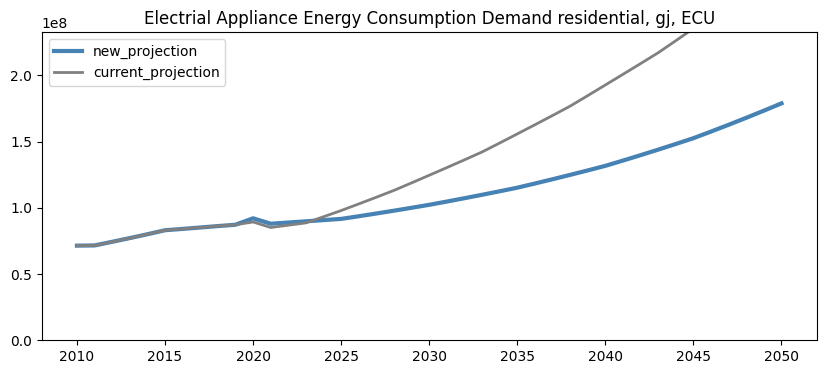

In [83]:
#######################
#    EXPORT IMAGES    #
#######################

dir_tmp = "/Users/jsyme/Desktop/figs_tmp"
os.makedirs(dir_tmp, exist_ok = True) if not os.path.exists(dir_tmp) else None


iso = "ECU"
field_gdp_per_cap = "gdp_per_capita_usd"
df = pd.merge(
    df_elasticities,
    df_consumption,
    how = "left"
)

df = df[df[field_iso3].isin([iso])].reset_index(drop = True)
fields_drop = set(df_inputs.columns) & set(df.columns) - set([field_iso3, field_year])

df = pd.merge(
    df,
    df_inputs.drop(fields_drop, axis = 1), 
    how = "left"
)
df = time_periods.years_to_tps(df)
df_se = model_socioeconomic(
    df, 
    ignore_time_periods = True,
    project_for_internal = False
)

df = pd.merge(df, df_se, how = "left")



for cat in ["residential"]:# cats_prod:
    
    vec_years = np.array(df[field_year]).astype(int)
    
    vec_gdp = np.array(df[field_gdp_per_cap])
    vec_gdp_change = vec_gdp[1:]/vec_gdp[0:-1] - 1
    field_elast = f"elasticity_scoe_enerdem_per_hh_{cat}_elec_appliances_to_gdppc"
    vec_elast = np.array(df[field_elast])
    
    vec_prod_proj_edmundo = np.array(df_inputs[df_inputs[field_iso3].isin([iso])][f"consumpinit_scoe_gj_per_hh_{cat}_elec_appliances"])
     
    prod_init = vec_prod_proj_edmundo[0]
    vec_prod = prod_init*sf.project_growth_scalar_from_elasticity(vec_gdp_change, vec_elast)
    vec_hh = np.array(df["qty_gnrl_households"])
    
    vec_prod *= vec_hh
    vec_prod_proj_edmundo *= vec_hh
    
    fig, ax = plt.subplots(figsize = (10, 4))
    
    ax.set_ylim((0, max(vec_prod)*1.3))
    ax.set_title(f"Electrial Appliance Energy Consumption Demand {cat}, gj, {iso}")
    ax.plot(vec_years, vec_prod, label = "new_projection", linewidth = 3, color = "steelblue")
    ax.plot(vec_years, vec_prod_proj_edmundo, label = "current_projection", linewidth = 2, color = "gray")
    ax.legend()
    
    plt.show()
    #plt.savefig(os.path.join(dir_tmp, f"prod_comparison_{cat}.jpg"), dpi = 100)

    
    

In [8]:
26.2*1.012**29

37.028502941965975

In [9]:
1.012**29

1.4133016390063349